In [147]:
import sys
sys.path.append("../src/") 
import os

import model_manipulation as mm
import cobra
import cplex 
import libsbml
import pandas as pd
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
from cobra import Reaction


In [5]:
#Read 2-cell model
model = cobra.io.read_sbml_model("../model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6
model.solver = 'gurobi'


In [112]:
#This codeblock is to define some functions that will be used for modelling.


#Define linear relationship between PPFD and Cellular maintainance costs
#This formula comes from Topfer et al (2020) where she defined NGAM in a linear relationship with incident light
def compute_ngam_atp(ppfd):
    v_atp = 0.0049*ppfd + 2.7851
    return v_atp


#This function is used to set the inputs to the model used. 
def define_model_medium(model, co2, o2, ppfd, 
                        medium_dir='../misc/photo_medium.csv', no3=inf, h2o=inf, h=inf, 
                        nh4=inf, pi=inf):
    model_photo_media = mm.read_medium_csv(medium_dir, model)
    model_photo_media['EX_no3(e)'] = no3
    model_photo_media['EX_h2o(e)'] = h2o
    model_photo_media['EX_h(e)'] = h
    model_photo_media['EX_nh4(e)'] = nh4
    model_photo_media['EX_co2(e)'] = co2
    model_photo_media['EX_o2(e)'] = o2
    model_photo_media['EX_photonVis(e)'] = ppfd
    model_photo_media['EX_pi(e)'] = pi
    #Set set model medium as model
#     print('Added model medium')
    return model_photo_media

    
def turn_off_cofac_cycles(model, inact_dir='../misc/leaf_inactivated.tsv'):
    file = csv.reader(open(inact_dir), delimiter='\t')
    leaf_inactive_rxns = list()
    for rows in file:
        row_m = str()
        row_bs = str()
        for rxns in rows:
            row_m += str(rxns) + "_M"
            row_bs += str(rxns) + "_BS"
        leaf_inactive_rxns.append(row_m)
        leaf_inactive_rxns.append(row_bs)
        
    for rxns in model.reactions:
        if rxns.id in leaf_inactive_rxns:
            rxns.bounds = (0,0)
#     print('Successfully turned off cofactor-cycling reactions')

    
# #Add constraints to model
#This code block contains constraints that would simulate the assimilation rates of bs and m cells in a two-cell system (such as those seen near the midvein region of rice leaves)
# #BS photon flux must be the same/less than M flux (Adapted from B&B, 2019)
# photon_import = model.reactions.get_by_id("EX_photonVis(e)")
def add_tissue_constraints(model):
    BS_photon_import = model.reactions.PRISM_white_LED_BS
    M_photon_import = model.reactions.PRISM_white_LED_M

    #Set photon flux ratio to 10:1
    photon_flux = mm.set_fix_flux_ratio({M_photon_import.id:10, BS_photon_import.id:1},model)
    model.add_cons_vars(photon_flux)

    co2tex_m = model.reactions.CO2tex_M
    co2tex_bs = model.reactions.CO2tex_BS

    #CO2 Uptake must be constrained to A (Net assimilation rate) which is around 29 +- 1.2 umol CO2 m-2 s-1 for wild type rice
    #CO2 BS intake must be limited owing to its position in the leaf tissue

    # # #CO2 intake needs to be mostly in the M cells. Not sure of the exact value:
    # # Values from Von Caemmerer (2000) in intermediate C3-C4 photosynthetic plants is 1 mmol CO2 m-2 s-1 per 20 CO2 m-2 s-1, which puts it at 20:1 ratio
    # # #try checking Danila et al. (2016) on ratio of surface area of M cell to BS cell
    # # #I'll assume that the ratio is at 20:1 in the meantime, meaning that there is minimal gas exchange into the BS cell that would equate to around ~1 umol CO2 m-2s-1
    co2_ratio_cons = mm.set_fix_flux_ratio({co2tex_m.id:10, co2tex_bs.id:1},model)
    co2_ratio_cons.name = 'co2_ratio_cons'
    model.add_cons_vars(co2_ratio_cons)

    #o2 ratio constraint
    o2tex_bs = model.reactions.O2tex_BS
    o2tex_m = model.reactions.O2tex_M

    o2_ratio_cons = mm.set_fix_flux_ratio({o2tex_m.id:10, o2tex_bs.id:1},model)
    o2_ratio_cons.name = 'o2_ratio_cons'
    model.add_cons_vars(o2_ratio_cons)

    #no tissue-specific constraints will be set for Nitrates, h2o and other inorganic cofactors as 
    #they are transported via the apoplastic pathway rather than the symplast

    # #This code block contains constraints specific for enzyme rate constraints
    #This approach is derived from Bogart & Myers (2016) where they constrained the enzyme rate 
    #fluxes in each of the 2-cell segments to a specific upper bound while keeping the lower bound
    #At 0. For reversible reactions the lower bounds are set to the same value

def add_enzyme_constraints(model):
    #Maximum values for constraints
    wt_pepc = 0 #umol m-2 s-1 #Note: Need to constrain it to 0 pala since no PEPC was detected in either cell type
    wt_mdh = 11.18 #umol m-2 s-1
    wt_nadp_me = 0.14 #umol m-2 s-1
    wt_ppdk = 0.31 #umol m-2 s-1
    wt_CA = 7.5 #umol m-2  s-1 bar-1 (Constrained to CO2 amounting to 400-500 mbar) (1 bar = 15.74 umol m-2 s-1 CA activity)

    #PEPC constraint (Reaction id: PPCc)
    #Need to constrain it to 0 since reaction is only detected in Vascular tissue
    pepc_BS = model.reactions.PPCc_BS
    pepc_M = model.reactions.PPCc_M

    wt_pepc_cons = model.problem.Constraint(pepc_BS.flux_expression 
                                            + pepc_M.flux_expression, 
                                            lb = 0, ub = wt_pepc)
    wt_pepc_cons.name = 'wt_pepc_cons'
    model.add_cons_vars(wt_pepc_cons)

    #PPDK constraints (Reaction id: PPDKs) (note that this is found in the chloroplast?) 
    #Not detected via immunolocalization but enzyme activity is detected

    ppdks_BS = model.reactions.PPDKs_BS
    ppdks_M = model.reactions.PPDKs_M
    wt_ppdks_cons = model.problem.Constraint(ppdks_BS.flux_expression 
                                             + ppdks_M.flux_expression, 
                                             lb = 0, ub = wt_ppdk)
    wt_ppdks_cons.name = 'wt_ppdks_cons'
    model.add_cons_vars(wt_ppdks_cons)
    #Malate Dehydrogenase 
    #Only mitochondrial in WT Rice M cells
    mdhm_M = model.reactions.MDHm_M


    wt_mdh_cons = model.problem.Constraint(mdhm_M.flux_expression,
                                           lb= 0, ub=wt_mdh)
    wt_mdh_cons.name = "wt_mdh_cons"
    model.add_cons_vars(wt_mdh_cons)

    #NADP-ME (Since no signal is detected in WT, no locational constraints are imposed)
    #Let's see if I can force it to have a small amount of flux 
    nadp_me_M = model.reactions.MDHys_M
    nadp_me_BS = model.reactions.MDHys_BS

    wt_nadpme_cons = model.problem.Constraint(nadp_me_M.flux_expression
                                             + nadp_me_BS.flux_expression,
                                             lb= 0, ub=wt_nadp_me)
    wt_nadpme_cons.name = "wt_nadpme_cons"
    model.add_cons_vars(wt_nadpme_cons)


    #I should add constraints for Carbonic Anhydrase
    #I should constrain it to 0.4 ubar, which would constitute ambient CO2 partial pressure
    #Flux is reversible so constraints are bi-directional


    hco3es_m = model.reactions.HCO3Es_M.flux_expression
    hco3ec_m = model.reactions.HCO3Ec_M.flux_expression
    hco3em_m = model.reactions.HCO3Em_M.flux_expression
    hco3es_bs = model.reactions.HCO3Es_BS.flux_expression
    hco3ec_bs = model.reactions.HCO3Ec_BS.flux_expression
    hco3em_bs = model.reactions.HCO3Em_BS.flux_expression

    ca_cons = model.problem.Constraint(hco3es_m + hco3ec_m + hco3em_m 
                                       + hco3es_bs + hco3ec_bs + hco3em_bs,
                                      lb = -wt_CA, ub = wt_CA)
    ca_cons.name = 'Carbonic_anhydrase_constraint'
    model.add_cons_vars(ca_cons)
    #Rbcl constaints
    #Retrieve flux expressions oof each RBCl reaction
    rbpc_M = model.reactions.RBPCs_M.flux_expression
    rbpc_BS = model.reactions.RBPCs_BS.flux_expression
    rbpo_M = model.reactions.RBPOs_M.flux_expression
    rbpo_BS = model.reactions.RBPOs_BS.flux_expression

    #Constraint such that it is limited to 132 umol m-2 s-1
    rbcl_vcmax_cons = model.problem.Constraint(rbpc_M + rbpc_BS, lb = 0, ub= 132)
    rbcl_vcmax_cons.name='rbcl_vcmax_cons'
    model.add_cons_vars(rbcl_vcmax_cons)
    #Constraints for rbcl flux such that v_c/v_o = 3 or higher.
    rbcl_vcvo = model.problem.Constraint(3*(rbpo_M + rbpo_BS) 
                                         - 1*(rbpc_M + rbpc_BS),
                                         lb=0,ub=1000)
    rbcl_vcvo.name = 'rbcl_vc/vo_ratio'
    model.add_cons_vars(rbcl_vcvo)

    #Turn off the RBPC2s reactions since we already defined the constraints above
    model.reactions.RBPC2s_M.bounds = (0,0)
    model.reactions.RBPC2s_BS.bounds = (0,0)
    
    
    
    #What if I simply constrained that of the M cell one to 3:1?
    #This constraint is pretty good actually. 
    #This allows the system to be set at a specific Vc/Vo rate while still allowing local variation 
    #wherein Rubisco may act in an uncoupled fashion and may have favorable internal vc/vo rates.
# #This code block is to set a constraint such that M-to-BS cell NGAM ratio is 10-to-1 
# #Similar to what Moreno-Villena (2021) (preprint) had done 

#This function takes two arguments: the model and the maximal  ppfd input to the system
def add_ngam_cons(model, ppfd): 
    ngam_atp_m = mm.get_rxn(model, 'ngam_atp_c_M')
    ngam_atp_bs = mm.get_rxn(model, 'ngam_atp_c_BS')
    ngam_atp_m.bounds = (0,1000)
    ngam_atp_bs.bounds = (0,1000)
    ngam_ratio = mm.set_fix_flux_ratio({ngam_atp_m.id:10, ngam_atp_bs.id:1}, model)
    ngam_ratio.name = 'ngam_BS/M_ratio'
    model.add_cons_vars(ngam_ratio)

    #Retrieve NGAM reactions
    ngam_nadphox_c_M = mm.get_rxn(model, 'ngam_nadphox_c_M')
    ngam_nadphox_s_M = mm.get_rxn(model, 'ngam_nadphox_s_M')
    ngam_nadphox_m_M = mm.get_rxn(model, 'ngam_nadphox_m_M')
    ngam_nadphox_c_BS = mm.get_rxn(model, 'ngam_nadphox_c_BS')
    ngam_nadphox_s_BS = mm.get_rxn(model, 'ngam_nadphox_s_BS')
    ngam_nadphox_m_BS = mm.get_rxn(model, 'ngam_nadphox_m_BS')


    #Set Fixed fluxes
    nadphox_c_s_M = mm.set_fix_flux_ratio({ngam_nadphox_c_M.id:1, ngam_nadphox_s_M.id:1},model)
    nadphox_c_s_M.name = "nadphox_cs_ratio_M"
    nadphox_s_m_M = mm.set_fix_flux_ratio({ngam_nadphox_s_M.id:1, ngam_nadphox_m_M.id:1}, model)
    nadphox_s_m_M.name = "nadphox_sm_ratio_M"

    nadphox_c_s_BS = mm.set_fix_flux_ratio({ngam_nadphox_c_BS.id:1, ngam_nadphox_s_BS.id:1},model)
    nadphox_c_s_BS.name = "nadphox_cs_ratio_BS"
    nadphox_s_m_BS = mm.set_fix_flux_ratio({ngam_nadphox_s_BS.id:1, ngam_nadphox_m_BS.id:1}, model)
    nadphox_s_m_BS.name = "nadphox_sm_ratio_BS"

    #Add constraints
    model.add_cons_vars(nadphox_c_s_M)
    model.add_cons_vars(nadphox_s_m_M)
    model.add_cons_vars(nadphox_c_s_BS)
    model.add_cons_vars(nadphox_s_m_BS)

    #Retrieve flux expressionns
    fex_nadphox_c_M =  mm.get_flux_exp(model, ngam_nadphox_c_M)
    fex_nadphox_s_M = mm.get_flux_exp(model, ngam_nadphox_s_M)
    fex_nadphox_m_M = mm.get_flux_exp(model, ngam_nadphox_m_M)

    fex_nadphox_c_BS =  mm.get_flux_exp(model, ngam_nadphox_c_BS)
    fex_nadphox_s_BS =  mm.get_flux_exp(model, ngam_nadphox_s_BS)
    fex_nadphox_m_BS =  mm.get_flux_exp(model, ngam_nadphox_m_BS)

    fex_atp_c_M = mm.get_flux_exp(model, ngam_atp_m)
    fex_atp_c_BS =  mm.get_flux_exp(model, ngam_atp_bs)

    #Set the constraint between ATP:NADPH NGAM to 3:1
    nadphox_atpase = model.problem.Constraint(3*(fex_nadphox_c_M + fex_nadphox_s_M + fex_nadphox_m_M
                                                       + fex_nadphox_c_BS + fex_nadphox_s_BS + fex_nadphox_m_BS) 
                                         - 1*(fex_atp_c_M + fex_atp_c_BS),
                                         lb=0,ub=0)
    nadphox_atpase.name = "nadphox_atpase_ratio"
    model.add_cons_vars(nadphox_atpase)
    #Compute NGAM value and add constraint as a lower bound/upper bound to model
    ngam_value = compute_ngam_atp(ppfd)
    ngam_cons = model.problem.Constraint(fex_atp_c_M + 
                                        fex_atp_c_BS, lb=ngam_value, ub=ngam_value)
    ngam_cons.name = 'NGAM_ATP_constraint'
    model.add_cons_vars(ngam_cons)
    
#This code  block gives a snapshot of the relevant fluxes on each of the cell types based on the saved sample_fluxes values above

def print_summary(sample_fluxes_df):
    print('rbcl M cell: ', sample_fluxes['RBPCs_M'], 'rbcl BS cell: ',sample_fluxes['RBPCs_BS'])
    print('rbcl M cell (photorespiration)', sample_fluxes['RBPOs_M'], 'rbcl BS cell (PR)', sample_fluxes['RBPOs_BS'])
    print('vc/vo M:', sample_fluxes['RBPCs_M']/sample_fluxes['RBPOs_M'], 'vc/vo BS:', sample_fluxes['RBPCs_BS']/sample_fluxes['RBPOs_BS'])
    print('RBPC2s_M', sample_fluxes['RBPC2s_M'], 'RBPC2s_BS', sample_fluxes['RBPC2s_BS'])
    print('PEPC M', sample_fluxes['PPCc_M'], 'PEPC BS', sample_fluxes['PPCc_BS'])
    print('Carbonic Anhydrase (Cytosolic) M', sample_fluxes['HCO3Ec_M'], 'Carbonic Anhydrase (Cytosolic) BS', sample_fluxes['HCO3Ec_BS'])
    print('NADP-ME M', sample_fluxes['MDHys_M'], 'NADP-ME BS', sample_fluxes['MDHys_BS'])
    print('Biomass M: ', sample_fluxes['Straw_Biomass_M'], 'Biomass BS', sample_fluxes['Straw_Biomass_BS'])
    print('Phloem M: ', sample_fluxes['DM_Phloem_M'], 'Phloem BS', sample_fluxes['DM_Phloem_BS'])
    print('co2 consumption M', sample_fluxes['CO2tex_M'], 'co2 consumption BS', sample_fluxes['CO2tex_BS'])
    print('o2 consumption M', sample_fluxes['O2tex_M'], 'o2 consumption BS', sample_fluxes['O2tex_BS'])
    print('Photosystem II M', sample_fluxes['PSIINC_M'], 'PSII BS', sample_fluxes['PSIINC_BS'])
    print('PSI M', sample_fluxes['PSIMR_M'], 'PSI BS', sample_fluxes['PSIMR_BS'])
    print('PPFD M: ', sample_fluxes['PRISM_white_LED_M'], 'PPFD BS: ', sample_fluxes['PRISM_white_LED_BS'])
    print('ATP synthesis (stromal) M', sample_fluxes['ATPSs_M'], 'ATP synthase (mit) M', sample_fluxes['ATPSm_M'])
    pd_rxn = [x for x in model.reactions if "pd" in x.id and "h2o" not in x.id]
    pd_abs_flux = 0
    for pds in pd_rxn:
        pd_abs_flux += abs(sample_fluxes[pds.id])
    
    print('pd_abs_flux: ', pd_abs_flux)

#Add transgenic reactions to model localized to specific compartment

Transgenic (Line 29 - Ermakova et al)
PEPC = Chloroplastic in M & V (rxn id: PPCc)
PPDK = Chloroplastic in M and BS (rxn id: PPDKs)
NADP-ME = Mitochondrial in M (rxn id: MDHys)
MDH = Chloroplastic in M and BS; Mitochondrial in M  (rxn id: MDH2s, MDH2c)
CA = Cytosolic in M (rxn id: hco3ec)

In WT:
PEPC = Cytosolic in V
PPDK = No signal
NADP-ME = No signal
MDH = Mitochondrial in M 
CA = No signal

Difference:
PEPC = Only in M
PPDK = Chloroplastic M & BS
NADP-ME = Only in M
MDH = Chloroplastic in M/BS
CA = Cytosolic in M



In [ ]:
#My approach would be to add two linear constraints corresponding to the WT and the transgenic
#Enzyme reaction rates, respectively. The first layer of constraints represents WT conditions while
#the second constraints represents the Transgenic conditions wherein 


In [113]:
#initialize list of transgenic reactions to add  to model

def add_trans_reactions(model):
    '''
    This function is used to add a number of new tissue-specific reactions that were not present in the
    original model to facilitate modelling of the transgenic C4 rice
    '''
    trans_list = list()
    #Transgenic PEPC copy
    #PEPC = Chloroplastic in M & V (rxn id: PPCc)
    trans_ppcs = Reaction('trans_PPCs_M')
    trans_ppcs.name = "Phosphoenolpyruvate carboxylase, plastidic (Transgenic)"

    co2_s0 = model.metabolites.co2_s0
    h_s0 = model.metabolites.h_s0
    pep_s0 = model.metabolites.pep_s0
    h2o_s0 = model.metabolites.h2o_s0
    oaa_s0 = model.metabolites.oaa_s0
    pi_s0 = model.metabolites.pi_s0


    #Add metabolites, bounds, and subsystem
    trans_ppcs.add_metabolites({co2_s0:-1, h_s0:-1, pep_s0:-1, h2o_s0:1, oaa_s0:1, pi_s0:1})
    trans_ppcs.bounds= model.reactions.PPCc_M.bounds
    trans_ppcs.subsystem = model.reactions.PPCc_M.subsystem

    trans_list.append(trans_ppcs)


    #Transgenic PPDK Copy
    #Since it already exists I'll just copy and readd it
    trans_ppdks_m = Reaction('trans_PPDKs_M')
    trans_ppdks_m.add_metabolites(model.reactions.PPDKs_M.metabolites)
    trans_ppdks_m.bounds = model.reactions.PPDKs_M.bounds
    trans_ppdks_m.name = "Pyruvate phosphate dikinase, plastidic (Transgenic)"

    trans_ppdks_bs = Reaction('trans_PPDKs_BS')
    trans_ppdks_bs.add_metabolites(model.reactions.PPDKs_BS.metabolites)
    trans_ppdks_bs.bounds = model.reactions.PPDKs_BS.bounds
    trans_ppdks_bs.name = "Pyruvate phosphate dikinase, plastidic (Transgenic)"

    trans_list.append(trans_ppdks_m)
    trans_list.append(trans_ppdks_bs)


    #Transgenic NADP-ME
    #NADP-ME = Mitochondrial in M
    trans_nadp_me = Reaction('trans_MDHym_M')

    #retrieve reactants
    mal_m0 = model.metabolites.get_by_id('mal-L_m0')
    nadp_m0 = model.metabolites.nadp_m0
    h_m0 = model.metabolites.h_m0
    nadph_m0 = model.metabolites.nadph_m0
    oaa_m0 = model.metabolites.oaa_m0

    #Add to rxn
    trans_nadp_me.add_metabolites({mal_m0:-1, nadp_m0:-1, h_m0:1, nadph_m0:1, oaa_m0:1})
    #Add bounds
    trans_nadp_me.bounds=(-inf, inf)

    trans_list.append(trans_nadp_me)


    #Malate Dehydrogenase, mitochondrial (M cell)
    trans_MDHm_M = Reaction('trans_MDHm_M')
    trans_MDHm_M.name = 'Malate Dehydrogenase, Mitochondrial'
    trans_MDHm_M.add_metabolites(model.reactions.MDHm_M.metabolites)
    trans_MDHm_M.subsystem = model.reactions.MDHm_M.subsystem

    trans_list.append(trans_MDHm_M)

    #Malate dehydrogenase, plastidic (M cell)
    trans_MDHs_M = Reaction('trans_MDHs_M')
    trans_MDHs_M.name = 'Malate Dehydrogenase, Plastidic'
    trans_MDHs_M.add_metabolites(model.reactions.MDHs_M.metabolites)
    trans_MDHs_M.subsystem = model.reactions.MDHs_M.subsystem

    trans_list.append(trans_MDHs_M)

    #Malate dehydrogenase, plastidic(BS Cell)
    trans_MDHs_BS = Reaction('trans_MDHs_BS')
    trans_MDHs_BS.name = 'Malate Dehydrogenase, Plastidic'
    trans_MDHs_BS.add_metabolites(model.reactions.MDHs_BS.metabolites)
    trans_MDHs_BS.subsystem = model.reactions.MDHs_BS.subsystem

    trans_list.append(trans_MDHs_BS)


    #Trans CA
    #Cytosolic in M
    trans_hco3ec_M = Reaction('trans_hco3ec_M')
    trans_hco3ec_M.name = 'carbonic anhydrase, cytosolic'
    trans_hco3ec_M.add_metabolites(model.reactions.HCO3Ec_M.metabolites)
    trans_hco3ec_M.bounds = model.reactions.HCO3Ec_M.bounds

    trans_hco3ec_M.subsystem = model.reactions.HCO3Ec_M.subsystem
    trans_list.append(trans_hco3ec_M)


    #Bulk add to model
    model.add_reactions(trans_list)
    
    model.repair()
#     print("Successfully added transgenic reactions")
#     print('List of reactions added: ')
#     for items in trans_list:
#         print(items.id)


In [157]:


def add_trans_constraints(model):
    '''
    This function is used to add another layer of constraints to parametize model based on the
    Enzyme reaction rates assayed from Ermakova et al (2021) where the locations are based on the 
    each of the transgenic enzyme's tissue-specific localizations. 
    '''
    
    #The following code block is done to
    #Define rates
    trans_pepc_rates = 7.01 #umol m-2 s-1
    trans_ppdks_rates = 3.66 #umol m-2 s-1
    trans_mdh_rates = 152.87 #umol m-2 s-1
    trans_nadp_me_rates = 0.60 #umol m-2 s-1
    trans_CA_rates = 8 #umol m-2  s-1 bar-1 (Constrained to CO2 amounting to 400-500 mbar) (1 bar = 15.74 umol m-2 s-1 CA activity)


    #Generate constraints on top of WT constraints

    #Retrieve trans reactions
   

    #PEPC constraint
    wt_PPCc_M = mm.get_rxn(model, 'PPCc_M')
    wt_PPCc_BS = mm.get_rxn(model, 'PPCc_BS')
    trans_PPCs_M = mm.get_rxn(model, 'trans_PPCs_M')                           
    trans_PEPC_cons = model.problem.Constraint(trans_PPCs_M.flux_expression
                                            +wt_PPCc_BS.flux_expression 
                                            + wt_PPCc_M.flux_expression, 
                                            lb = 0, ub = trans_pepc_rates)

    model.add_cons_vars(trans_PEPC_cons)

    #PPDK constraint
    trans_PPDKs_M  = mm.get_rxn(model, 'trans_PPDKs_M')
    trans_PPDKs_BS = mm.get_rxn(model, 'trans_PPDKs_BS')
    wt_PPDKs_M = mm.get_rxn(model, 'PPDKs_M')
    wt_PPDKs_BS = mm.get_rxn(model, 'PPDKs_BS')
    
    trans_PPDKs_cons = model.problem.Constraint( 
        trans_PPDKs_BS.flux_expression + trans_PPDKs_M.flux_expression 
        +wt_PPDKs_BS.flux_expression + wt_PPDKs_M.flux_expression, 
                                             lb = 0, ub = trans_ppdks_rates)
    trans_PPDKs_cons.name = 'trans_ppdks_cons'
    model.add_cons_vars(trans_PPDKs_cons)


    #Malate Dehydrogenase Constraints
    trans_MDHm_M = mm.get_rxn(model, 'trans_MDHm_M')
    trans_MDHs_M = mm.get_rxn(model, 'trans_MDHs_M')
    trans_MDHs_BS = mm.get_rxn(model, 'trans_MDHs_BS')
    wt_MDHm_M =  mm.get_rxn(model, 'MDHm_M')
    wt_MDHs_M = mm.get_rxn(model, 'MDHs_M')
    wt_MDHs_BS = mm.get_rxn(model, 'MDHs_BS')
    
    trans_mdh_cons =  model.problem.Constraint(
       trans_MDHm_M.flux_expression + 
        wt_MDHm_M.flux_expression + 
        trans_MDHs_M.flux_expression + 
        trans_MDHs_BS.flux_expression +
        wt_MDHs_BS.flux_expression +
        wt_MDHs_M.flux_expression, 
        lb= 0, ub=trans_mdh_rates)

    trans_mdh_cons.name = "trans_mdh_cons"
    model.add_cons_vars(trans_mdh_cons)

    #Add NADP-ME constraints
    trans_MDHym_M = mm.get_rxn(model, 'trans_MDHym_M')
    wt_MDHys_M = mm.get_rxn(model, 'MDHys_M')
    wt_MDHys_BS = mm.get_rxn(model, 'MDHys_BS')
    
    trans_nadpme_cons = model.problem.Constraint(
        trans_MDHym_M.flux_expression + 
        wt_MDHys_M.flux_expression + 
        wt_MDHys_BS.flux_expression,
        lb= 0, ub=trans_nadp_me_rates)
    
    trans_nadpme_cons.name = "trans_nadpme"
    model.add_cons_vars(trans_nadpme_cons)

    #Add carbonic anhydrase constraints

    trans_hco3ec_M = mm.get_rxn(model, 'trans_hco3ec_M')
    wt_hco3ec_M = mm.get_rxn(model, 'HCO3Ec_M')
    wt_hco3em_M = mm.get_rxn(model, 'HCO3Em_M')
    wt_hco3es_M = mm.get_rxn(model, 'HCO3Es_M')
    wt_hco3ec_BS = mm.get_rxn(model, 'HCO3Ec_BS')
    wt_hco3em_BS = mm.get_rxn(model, 'HCO3Em_BS')
    wt_hco3es_BS = mm.get_rxn(model, 'HCO3Es_BS')
    
    trans_ca_cons = model.problem.Constraint(trans_hco3ec_M.flux_expression + 
                                             wt_hco3es_M.flux_expression + 
                                             wt_hco3ec_M.flux_expression + 
                                             wt_hco3em_M.flux_expression + 
                                             wt_hco3es_BS.flux_expression + 
                                             wt_hco3ec_BS.flux_expression + 
                                             wt_hco3em_BS.flux_expression,
                                      lb = -trans_CA_rates, ub = trans_CA_rates)
    trans_ca_cons.name = 'Trans_CA_cons'
    model.add_cons_vars(trans_ca_cons)
    model.repair()
#     print('Successfully added Transgenic-specific constraints')

This code block is to add the constraints for ngam nadphox, which for some reason doesn't save when it was generated using the curation script. I think this is because the constraint objects are only retrieved from the bounds encoded in the SBML.


In [115]:
# This code block is to test whether a single iteration works. Maybe I should implement the kinetic constraints by Von Caemmerer to obtain proper 
#proper values? I think that would be a better approach, I think.


with model as m1:
                                                                                                                                                                                                                                                                                                                      
    m1.medium = define_model_medium(m1, co2=26, o2=inf, ppfd=1599, h=inf, nh4=inf, no3=inf)
    turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    #Add trans constraints
    add_trans_reactions(m1)
    add_trans_constraints(m1)
    #Add NGAM
    add_ngam_cons(m1, 1599)

    #Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    model.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    model.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(model,'DM_Phloem_BS').objective_coefficient = 1
    sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes)
    
    sample_fluxes_df = sample_fluxes.to_frame()

print('\n')
print_summary(sample_fluxes_df)




rbcl M cell:  28.043993204661398 rbcl BS cell:  2.8641143916151393
rbcl M cell (photorespiration) 10.302702532092178 rbcl BS cell (PR) 0.0
vc/vo M: 2.7220035827790205 vc/vo BS: inf
RBPC2s_M 0.0 RBPC2s_BS 0.0
PEPC M 0.0 PEPC BS 0.0
Carbonic Anhydrase (Cytosolic) M 0.0 Carbonic Anhydrase (Cytosolic) BS 0.0
NADP-ME M 0.0 NADP-ME BS 0.0
Biomass M:  0.0 Biomass BS 0.0
Phloem M:  0.0 Phloem BS 0.41869262904510185
co2 consumption M 23.636363636364102 co2 consumption BS 2.36363636363641
o2 consumption M 0.0 o2 consumption BS 0.0
Photosystem II M 62.09817093736848 PSII BS 5.77688054638848
PSI M 92.90045139942079 PSI BS 9.613570073141224
PPFD M:  658.7227019035199 PPFD BS:  65.87227019035198
ATP synthesis (stromal) M 123.86726853256103 ATP synthase (mit) M 6.847808116163881
pd_abs_flux:  5.3822492180888775


<ipython-input-112-e92588d0051f>:255: RuntimeWarning: divide by zero encountered in double_scalars
  print('vc/vo M:', sample_fluxes['RBPCs_M']/sample_fluxes['RBPOs_M'], 'vc/vo BS:', sample_fluxes['RBPCs_BS']/sample_fluxes['RBPOs_BS'])


In [108]:
with model as m:
    add_trans_reactions(m)
    for items in model.reactions:
        if "trans" in items.id:
            print(items.id)

trans_PPCs_M
trans_PPDKs_M
trans_PPDKs_BS
trans_MDHym_M
trans_MDHm_M
trans_MDHs_M
trans_MDHs_BS
trans_hco3ec_M


In [159]:
#This code block is to generate a light scan for a mature leaf, which is done by setting
#The objective function to produce Phloem rather than Biomass.

add_trans_reactions(model)

ppfd_solns_2cell_fba = pd.DataFrame(index=list(i.id for i in model.reactions))

#Iterate from range 0 to 2000 w/ increments of 50 (max ppfd)

for ppfd in range(0,2000,50):
    
    #Generate instance of model every iteration
    with model as m1:
        #Set ATP NGAM value to linear PPFD formula

         #Set medium to change photon flux and other things and re-add to model
        m1.medium = define_model_medium(m1, co2=26.5, o2=2.26, ppfd=ppfd, h=inf, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        #Add trans constraints
        add_trans_constraints(m1)
        #Add NGAM to model
        add_ngam_cons(m1, ppfd)
    
        #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        m1.reactions.get_by_id('DM_Phloem_BS').objective_coefficient = 1

        #Optimize then check optimality
        while True:
            solution = model.optimize()
            if solution.status == 'optimal':
                sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
                #Remove thermodynamically infeasible loops via CycleFreeFlux algorithm
                sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes).to_frame()
                print("PPFD:", ppfd, " RBPC_M cell flux:", sample_fluxes['fluxes']['RBPCs_M'])
                #Append to Dataframe
                ppfd_solns_2cell_fba[ppfd] = sample_fluxes['fluxes']
                break


filepath = '../flux_results/PPFD_benchmark/Trans/'
filename = 'PPFD-benchmark-trans-model-Mature-Leaf'
mm.save_fba_matrix(filename, ppfd_solns_2cell_fba, filepath)

Ignoring reaction 'trans_PPCs_M' since it already exists.
Ignoring reaction 'trans_PPDKs_M' since it already exists.
Ignoring reaction 'trans_PPDKs_BS' since it already exists.
Ignoring reaction 'trans_MDHym_M' since it already exists.
Ignoring reaction 'trans_MDHm_M' since it already exists.
Ignoring reaction 'trans_MDHs_M' since it already exists.
Ignoring reaction 'trans_MDHs_BS' since it already exists.
Ignoring reaction 'trans_hco3ec_M' since it already exists.


PPFD: 0  RBPC_M cell flux: 2.2637578853874945
PPFD: 50  RBPC_M cell flux: 6.672132278330444
PPFD: 100  RBPC_M cell flux: 11.336992227346272
PPFD: 150  RBPC_M cell flux: 15.621892040744703
PPFD: 200  RBPC_M cell flux: 20.0050459316581
PPFD: 250  RBPC_M cell flux: 24.407294988387513
PPFD: 300  RBPC_M cell flux: 28.601270605653653
PPFD: 350  RBPC_M cell flux: 28.690802376091792
PPFD: 400  RBPC_M cell flux: 27.82322138866213
PPFD: 450  RBPC_M cell flux: 28.855296312956
PPFD: 500  RBPC_M cell flux: 28.040102685248797
PPFD: 550  RBPC_M cell flux: 29.29334085411984
PPFD: 600  RBPC_M cell flux: 28.874648159167748
PPFD: 650  RBPC_M cell flux: 28.73809078661197
PPFD: 700  RBPC_M cell flux: 28.651366123655098
PPFD: 750  RBPC_M cell flux: 28.65901618636076
PPFD: 800  RBPC_M cell flux: 28.65379638674414
PPFD: 850  RBPC_M cell flux: 28.64958248251033
PPFD: 900  RBPC_M cell flux: 28.645375202123798
PPFD: 950  RBPC_M cell flux: 28.641167921739083
PPFD: 1000  RBPC_M cell flux: 28.636960641357227
PPFD: 

In [160]:
#Run the simulation above  but setting biomass as primary
add_trans_reactions(model)
ppfd_solns_2cell_fba_bm = pd.DataFrame(index=list(i.id for i in model.reactions))

#Iterate from range 0 to 2000 w/ increments of 50 (max ppfd)

for ppfd in range(0,2000,50):
    
    #Generate instance of model every iteration
    with model as m1:
        #Set ATP NGAM value to linear PPFD formula

         #Set medium to change photon flux and other things and re-add to model
        m1.medium = define_model_medium(m1, co2=26.5, o2=2.26, ppfd=ppfd, h=inf, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        
        #Add trans constraints
        add_trans_constraints(m1)
        #Add NGAM to model
        add_ngam_cons(m1, ppfd)
    

        #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 1
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 1
        m1.reactions.get_by_id('DM_Phloem_BS').objective_coefficient = 0

        #Optimize then check optimality, repeat until solution is optimal
        while True:
            solution = model.optimize()

            if solution.status == 'optimal':
                sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
                #Remove thermodynamically infeasible loops via CycleFreeFlux algorithm
                sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes).to_frame()

                print("PPFD:", ppfd, " RBPC_M cell flux:", sample_fluxes['fluxes']['RBPCs_M'])
                #Append to Dataframe
                ppfd_solns_2cell_fba_bm[ppfd] = sample_fluxes['fluxes']
                
                break


filepath = '../flux_results/PPFD_benchmark/Trans/'
filename = 'PPFD-benchmark-trans-growing-leaf'
mm.save_fba_matrix(filename, ppfd_solns_2cell_fba_bm, filepath)

Ignoring reaction 'trans_PPCs_M' since it already exists.
Ignoring reaction 'trans_PPDKs_M' since it already exists.
Ignoring reaction 'trans_PPDKs_BS' since it already exists.
Ignoring reaction 'trans_MDHym_M' since it already exists.
Ignoring reaction 'trans_MDHm_M' since it already exists.
Ignoring reaction 'trans_MDHs_M' since it already exists.
Ignoring reaction 'trans_MDHs_BS' since it already exists.
Ignoring reaction 'trans_hco3ec_M' since it already exists.


PPFD: 0  RBPC_M cell flux: 2.26235151495295
PPFD: 50  RBPC_M cell flux: 6.721823387385316
PPFD: 100  RBPC_M cell flux: 11.218225406323464
PPFD: 150  RBPC_M cell flux: 15.689768716561357
PPFD: 200  RBPC_M cell flux: 20.17382005725105
PPFD: 250  RBPC_M cell flux: 24.848186826057923
PPFD: 300  RBPC_M cell flux: 29.14192273849755
PPFD: 350  RBPC_M cell flux: 29.418029157950144
PPFD: 400  RBPC_M cell flux: 29.262435131787147
PPFD: 450  RBPC_M cell flux: 29.220085524763874
PPFD: 500  RBPC_M cell flux: 29.324076913673267
PPFD: 550  RBPC_M cell flux: 29.220485380650004
PPFD: 600  RBPC_M cell flux: 29.116662383090627
PPFD: 650  RBPC_M cell flux: 29.006612977045613
PPFD: 700  RBPC_M cell flux: 29.396755200727977
PPFD: 750  RBPC_M cell flux: 29.379726901096397
PPFD: 800  RBPC_M cell flux: 29.308436100206873
PPFD: 850  RBPC_M cell flux: 29.268285028594057
PPFD: 900  RBPC_M cell flux: 29.25260959967439
PPFD: 950  RBPC_M cell flux: 29.251909913048376
PPFD: 1000  RBPC_M cell flux: 29.251210226464483


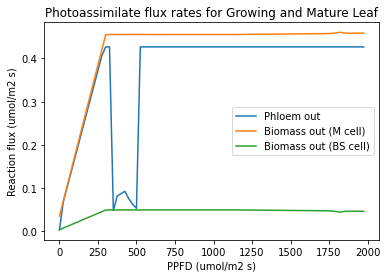

In [124]:
#Let's graph the initial results first

#plot PPFD vs CO2 uptake

co2_e = ppfd_solns_2cell_fba.loc[['EX_co2(e)']].values.flatten()
o2_e =ppfd_solns_2cell_fba.loc[['EX_o2(e)']].values.flatten()
nh4_e =  ppfd_solns_2cell_fba.loc[['EX_nh4(e)']].values.flatten()
no3_e =  ppfd_solns_2cell_fba.loc[['EX_no3(e)']].values.flatten()
phloem_out = ppfd_solns_2cell_fba.loc[['DM_Phloem_BS']].values.flatten()
biomass_out_M = ppfd_solns_2cell_fba_bm.loc[['Straw_Biomass_M']].values.flatten()
biomass_out_BS = ppfd_solns_2cell_fba_bm.loc[['Straw_Biomass_BS']].values.flatten()
ppfd_e = list(ppfd_solns_2cell_fba.columns)

plt.plot(ppfd_e, phloem_out, label="Phloem out")
plt.plot(ppfd_e, biomass_out_M, label="Biomass out (M cell)")
plt.plot(ppfd_e, biomass_out_BS, label="Biomass out (BS cell)")
plt.title(label='Photoassimilate flux rates for Growing and Mature Leaf')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Reaction flux (umol/m2 s)')
plt.legend()
plt.show()



#I think I need to graph previous data regarding this?
#Based on this, it shows that photoassimilation becomes unstable in intermediate lights  as opposed to
#Having a more stable output 

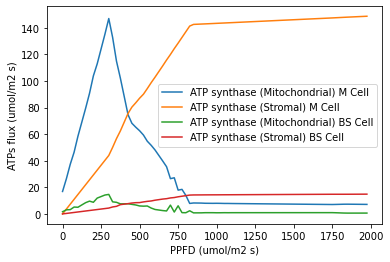

In [128]:
# Plot ATPs_M and ATPSs vs. ppfd
pd_values = ppfd_solns_2cell_fba_bm.loc[['ATPSs_BS']].values.flatten()




plt.plot(ppfd_e, ATPSm_m, label="ATP synthase (Mitochondrial) M Cell")
plt.plot(ppfd_e, ATPSs_m, label="ATP synthase (Stromal) M Cell")
plt.plot(ppfd_e, ATPSm_bs, label="ATP synthase (Mitochondrial) BS Cell")
plt.plot(ppfd_e, ATPSs_bs, label="ATP synthase (Stromal) BS Cell")
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('ATPs flux (umol/m2 s)')
plt.legend()
plt.show()


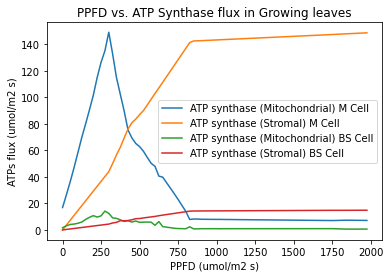

In [129]:
# Plot ATPs_M and ATPSs vs. ppfd in growing leaf
ATPSm_m =  ppfd_solns_2cell_fba_bm.loc[['ATPSm_M']].values.flatten()
ATPSs_m =  ppfd_solns_2cell_fba_bm.loc[['ATPSs_M']].values.flatten()
ATPSm_bs = ppfd_solns_2cell_fba_bm.loc[['ATPSm_BS']].values.flatten()
ATPSs_bs = ppfd_solns_2cell_fba_bm.loc[['ATPSs_BS']].values.flatten()



plt.plot(ppfd_e, ATPSm_m, label="ATP synthase (Mitochondrial) M Cell")
plt.plot(ppfd_e, ATPSs_m, label="ATP synthase (Stromal) M Cell")
plt.plot(ppfd_e, ATPSm_bs, label="ATP synthase (Mitochondrial) BS Cell")
plt.plot(ppfd_e, ATPSs_bs, label="ATP synthase (Stromal) BS Cell")
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('ATPs flux (umol/m2 s)')
plt.title('PPFD vs. ATP Synthase flux in Growing leaves')
plt.legend()
plt.show()


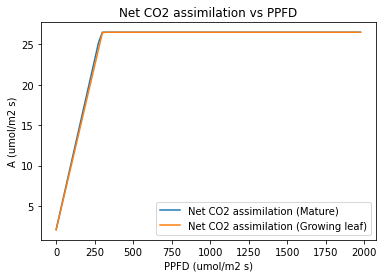

In [95]:
#Show CO2 assimilation comparing growing leaf and mature leaf
co2_e_mature = ppfd_solns_2cell_fba.loc[['EX_co2(e)']].values.flatten()
co2_e_growing = ppfd_solns_2cell_fba_bm.loc[['EX_co2(e)']].values.flatten()

plt.plot(ppfd_e, co2_e_mature *-1, label='Net CO2 assimilation (Mature)')
plt.plot(ppfd_e, co2_e_growing *-1, label='Net CO2 assimilation (Growing leaf)')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Net CO2 assimilation vs PPFD')
plt.legend()
plt.show()

#Weirdly enough it shows the same response

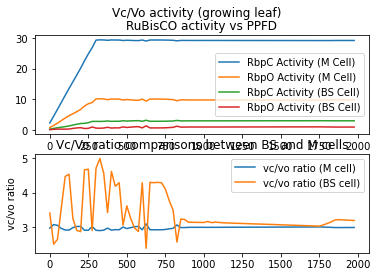

In [130]:
#Let's plot the RBCL activities per PPFD
rbpc_m = ppfd_solns_2cell_fba_bm.loc[['RBPCs_M']].values.flatten()
rbpo_m = ppfd_solns_2cell_fba_bm.loc[['RBPOs_M']].values.flatten()
rbpc_bs = ppfd_solns_2cell_fba_bm.loc[['RBPCs_BS']].values.flatten()
rbpo_bs = ppfd_solns_2cell_fba_bm.loc[['RBPOs_BS']].values.flatten()
vcvo_m = rbpc_m/rbpo_m
vcvo_bs = rbpc_bs/rbpo_bs



fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vc/Vo activity (growing leaf)')
# fig.set_xlabel('PPFD (umol/m2 s)')

ax1.plot(ppfd_e,  rbpc_m, label='RbpC Activity (M Cell)')
ax1.plot(ppfd_e, rbpo_m, label='RbpO Activity (M Cell)')
ax1.plot(ppfd_e,  rbpc_bs, label='RbpC Activity (BS Cell)')
ax1.plot(ppfd_e, rbpo_bs, label='RbpO Activity (BS Cell)')
ax1.set_xlabel('RubisCO Flux (umol/m2 s)')
ax1.set_title('RuBisCO activity vs PPFD')
ax1.legend()


ax2.plot(ppfd_e,  vcvo_m, label='vc/vo ratio (M cell)')
ax2.plot(ppfd_e, vcvo_bs, label='vc/vo ratio (BS cell)')
ax2.set_ylabel('vc/vo ratio')
ax2.set_title('Vc/Vo ratio comparisons between BS and M cells')
ax2.legend()



<ipython-input-131-1993ab215769>:7: RuntimeWarning: divide by zero encountered in true_divide
  vcvo_bs = rbpc_bs/rbpo_bs


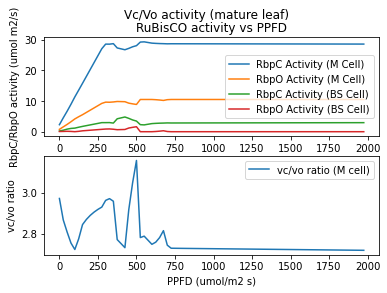

In [131]:
#Let's plot the RBCL activities per PPFD
rbpc_m = ppfd_solns_2cell_fba.loc[['RBPCs_M']].values.flatten()
rbpo_m = ppfd_solns_2cell_fba.loc[['RBPOs_M']].values.flatten()
rbpc_bs = ppfd_solns_2cell_fba.loc[['RBPCs_BS']].values.flatten()
rbpo_bs = ppfd_solns_2cell_fba.loc[['RBPOs_BS']].values.flatten()
vcvo_m = rbpc_m/rbpo_m
vcvo_bs = rbpc_bs/rbpo_bs

vcvo_total = (rbpc_m + rbpc_bs)/(rbpo_m + rbpo_bs)


fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vc/Vo activity (mature leaf)')

ax1.plot(ppfd_e,  rbpc_m, label='RbpC Activity (M Cell)')
ax1.plot(ppfd_e, rbpo_m, label='RbpO Activity (M Cell)')
ax1.plot(ppfd_e,  rbpc_bs, label='RbpC Activity (BS Cell)')
ax1.plot(ppfd_e, rbpo_bs, label='RbpO Activity (BS Cell)')
ax1.set_ylabel('RbpC/RbpO activity (umol m2/s)')
ax1.set_title('RuBisCO activity vs PPFD')
ax1.legend()

# ax2(ppfd_e,  vcvo_bs, label='vc/vo ratio (BS cell)')
ax2.plot(ppfd_e, vcvo_m, label='vc/vo ratio (M cell)')
ax2.set_xlabel('PPFD (umol/m2 s)')
ax2.set_ylabel('vc/vo ratio')
ax2.legend()
# ax2.set_title('Vc/Vo ratio comparisons between BS and M cells')


#Top is rubisco fluxes while bottom is vc/vo ratios. Note that the vc/vo ratios at the bottom portion 
#are disrupted due to zero values in a number of 

<AxesSubplot:>

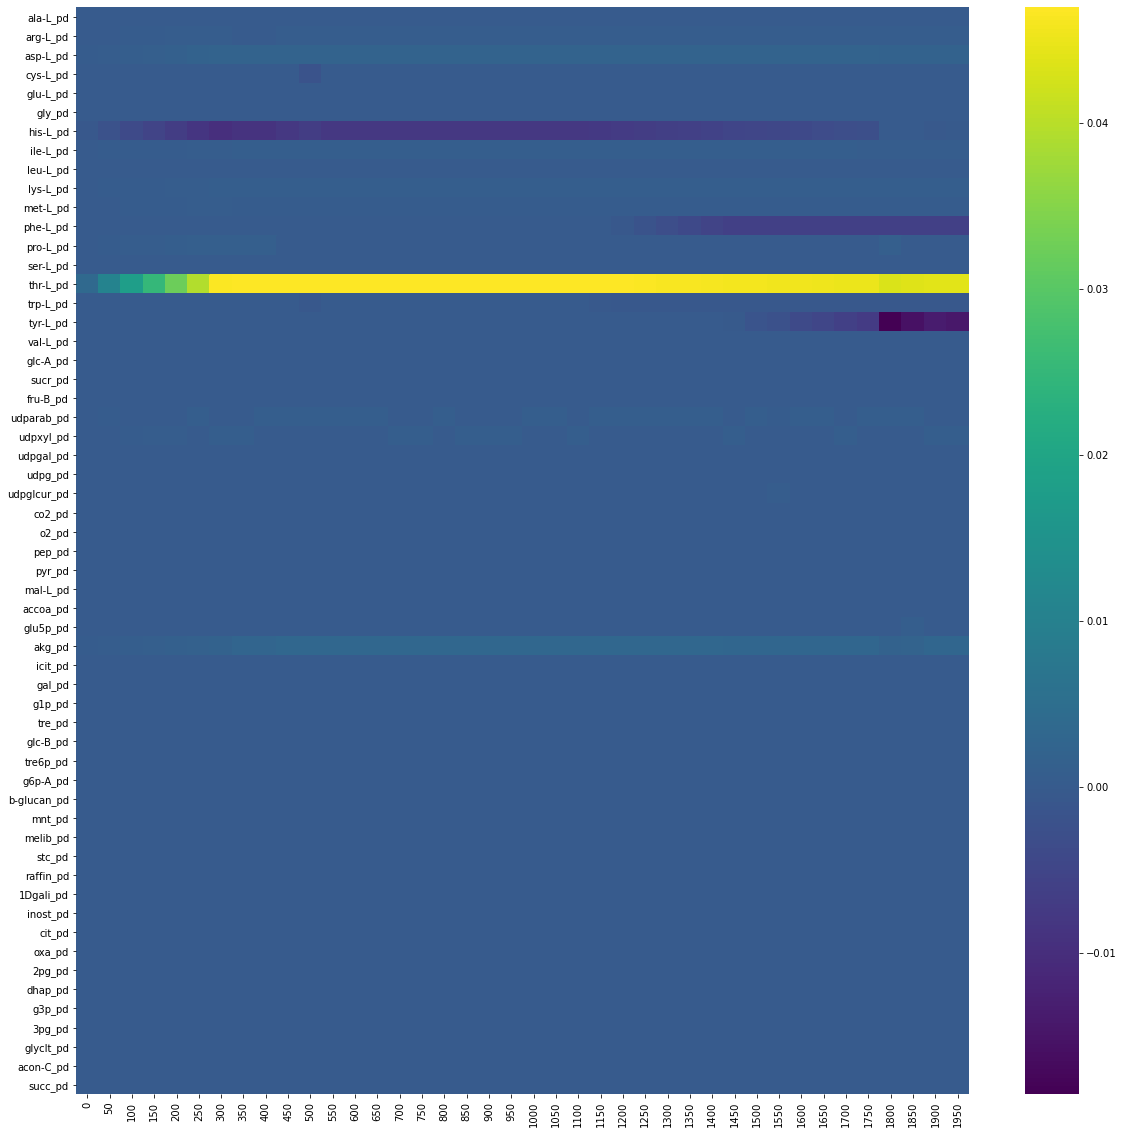

In [219]:
#This heat map shows the Plasmodesmatal reactions in a growing leaf
phloem_ppfd = ppfd_solns_2cell_fba_bm.transpose()
pd_transport_ids = [rxns.id for rxns in model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd_bm = phloem_ppfd[pd_transport_ids].transpose()



plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd_bm, cmap='viridis')

<function matplotlib.pyplot.show(close=None, block=None)>

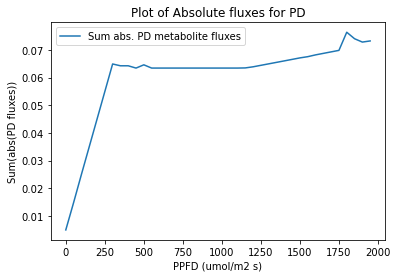

In [220]:
#This code block is to generate a bar graph showing PD sum of fluxes  per ppfd

pd_phloem_abs_flux_bm = pd_phloem_ppfd.abs().sum(axis=0)


plt.plot(pd_phloem_abs_flux_bm.index, pd_phloem_abs_flux_bm.values, label='Sum abs. PD metabolite fluxes')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Sum(abs(PD fluxes))')
plt.title('Plot of Absolute fluxes for PD')
plt.legend()
plt.show


<AxesSubplot:>

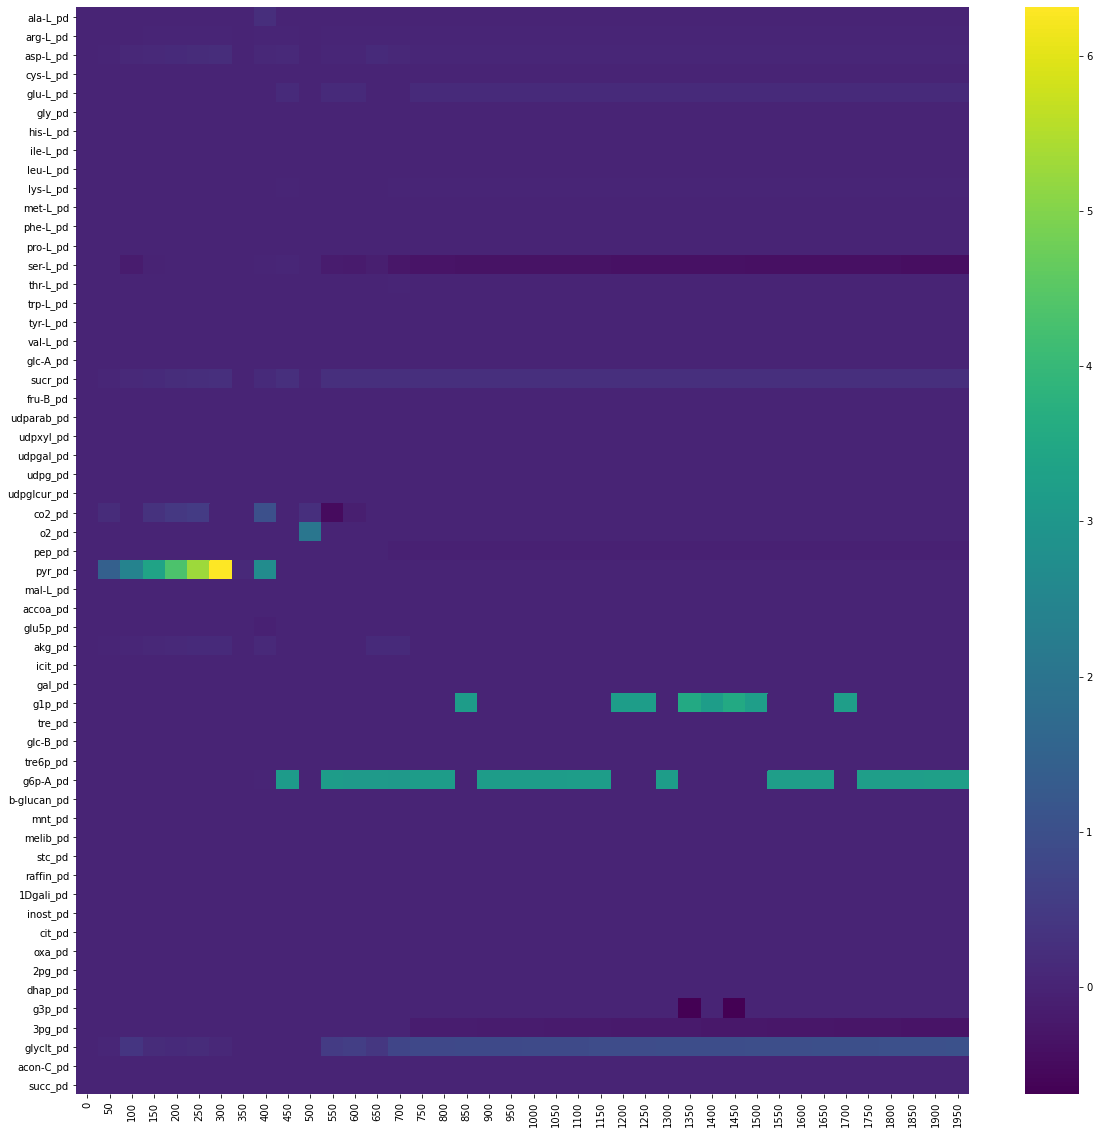

In [221]:
#This heat map shows the Plasmodesmatal reactions in the mature leaf
phloem_ppfd = ppfd_solns_2cell_fba.transpose()
pd_transport_ids = [rxns.id for rxns in model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd = phloem_ppfd[pd_transport_ids].transpose()
pd_phloem_ppfd.loc[~(pd_phloem_ppfd<-inf).all(axis=1)]



plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd, cmap='viridis')

<function matplotlib.pyplot.show(close=None, block=None)>

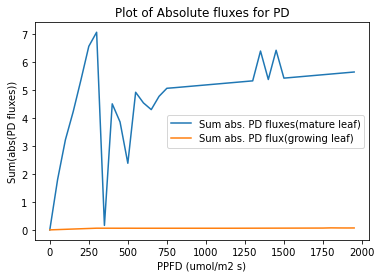

In [224]:
#This code block is to generate a bar graph showing PD sum of fluxes  per ppfd

pd_phloem_abs_flux = pd_phloem_ppfd.abs().sum(axis=0)


plt.plot(pd_phloem_abs_flux.index, pd_phloem_abs_flux, label='Sum abs. PD fluxes(mature leaf)')
plt.plot(pd_phloem_abs_flux_bm.index, pd_phloem_abs_flux_bm.values, label = 'Sum abs. PD flux(growing leaf)')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Sum(abs(PD fluxes))')
plt.title('Plot of Absolute fluxes for PD')
plt.legend()
plt.show


Initial thoughts:
- Based on the Light scan experiments above we can see quite a greater variation in terms of Phloem output between flux ranges 200 to 500, and we can also see a minor increase in Rubisco activity in the BS cells. However, I think this still needs to be tested via flux sampling to determine the actual range.
- A similar dip exists even in the Wild type mature leaf but generally stabilizes faster compared to the transgenic rice. 
- I believe this is linked to ATP balancing and the transition from Mitochondrial ATP production to stromal ATP production.

- FUrthermore, I've observed that Rubisco activiity is also limited by Formate Dehydrogenase activity. When it is closed, Rubisco activity is only limited to around ~40 umol m2/s flux values (30 vc + 10 vo) while increasing the upper bound of FDHNc to around 25 allows it to have a ceiling of ~80 umol m2/s, which is around the experimental Rubisco activity measured by Ermakova et al (2021)
    - However, turning this reaction on causes the model to produce ATP with a flux rate that's almost x2 that of previous modelling attempts as checked from Shameer et al (2018, 2021). Furthermore, in Shameer et al (2021) the ranges for Rubisco carboxylation plays around 28-31, which is the maximum rate observed in this experiment. I think this would be a more viable route if ever.
    - Furthermore, based on Shameer et al's hybrid model and flux distributions the ATPase flux values are quite concordant with each other.
    - Lastly, the results pertaining to ATP synthesis is quite concordant with the results obtained by Shameer et al in their 2018 publication wherein mito-stromal ATP synthase shift was also observed.
    
    - Weirdly enough I'm observing that the addition of the trans constraints caused the flow of CO2 directly from the M cell to the BS cell at moderate light conditions, as opposed to the WT. Furthermore, more background flux is observed in all cases in the transgenic 2 cell. 
        - I need to check whether the absolute fluxes actually varied in these cases.
    
    - In both WT and Transgenic models Pyruvate is the predominant flux at low to medium light levels, while in the Transgenic model there is actual Gas flux from M to BS cells (both CO2 and O2)
    - In the transgenic model some flux of Glycolate from the M cell is detected in high light conditions (>750 ppfd) while some backflow of g3p from the BS cell to the M cell is observed.
    

In [178]:
model.metabolites.glyclt_c0

Metabolite identifier,glyclt_c0
Name,Glycolate
Memory address,0x07fb44033f250
Formula,C2H3O3
Compartment,c0
In 4 reaction(s),"GLYCRts_M, GLYCLTtx_M, GCALDDc_M, glyclt_pd"


In [ ]:
#Note: Turning off other prism reactions (red, green, blue, etc) while retaining only white light reactions lowers net carbon assimilation
#I think this is in consideration on how white light is partitioned to several wavelengths, which prevents it from being fully utilized.

In [ ]:
#Other artifacts as of the moment include the following:
#model doesn't produce any Oxygen. Maybe I should add a specific demand reaction for it?
#Based on FVA, the model now produces some oxygen via the demand reaction. 

In [ ]:
#Model also facilitates transfer of metabolites unlike before.

In [ ]:
#Questions:
#Should I restrict Nutrient flow to the Bundle Sheath Cell only or should I allow flux to both the M and BS cell?
#Apparently kasi dito only the Bundle sheath cells produce any biomass
#This is to ensure that only CO2 and Light flux are the only limiting constraints to the system.